# Local Invariant Features
## Computer Vision and Image Processing - Lab Session 6 - Exercises
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Pierluigi Zama Ramirez, pierluigi.zama@unibo.it - Riccardo Spezialetti, riccardo.spezialetti@unibo.it

### Exercise 1: Object Detection
Given a query image ('ex/bishop.jpg') detect the object in the scene images: 'scene1.jpg', 'scene2.jpg' and 'scene3.jpg'.

In [14]:
# Write your solution here
import cv2
from matplotlib import pyplot as plt
import numpy as np
from pprint import pprint

def find_descriptors(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(img)
    kp, descr = sift.compute(img, kp)

    return kp, descr


def init_descr_matcher(n_trees, n_checks):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = n_trees)
    search_params = dict(checks = n_checks)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    return flann


def get_good_matches(matches, threshold):
    good = []
    for m,n in matches:
        if m.distance < threshold*n.distance:
            good.append(m)

    return good


def get_homography_and_mask(kp_query, kp_train, good, min_match_count):
    # Checking if we found enough matching
    MIN_MATCH_COUNT = min_match_count
    if len(good)>MIN_MATCH_COUNT:
        # building the corrspondences arrays of good matches
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        # It returns the homography M and a mask for the discarded points
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        matchesMask = mask.ravel().tolist()

    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    return M, matchesMask 


def draw_matches(img_query_path, img_train_path, min_match_count=10):
    img_query = cv2.imread(img_query_path, 0)
    img_train = cv2.imread(img_train_path, 0)

    kp_query, descr_query = find_descriptors(img_query)
    kp_train, decr_train = find_descriptors(img_train)

    flann = init_descr_matcher(n_trees=5, n_checks=50)

    matches = flann.knnMatch(descr_query,decr_train,k=2)

    good = get_good_matches(matches, threshold=0.7)

    _, matchesMask = get_homography_and_mask(kp_query, kp_train, good, min_match_count=min_match_count)

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2) # not draw keypoints only lines

    img3 = cv2.drawMatches(img_query,kp_query,img_train,kp_train,good,None,**draw_params)
    plt.imshow(img3, 'gray')
    plt.show()

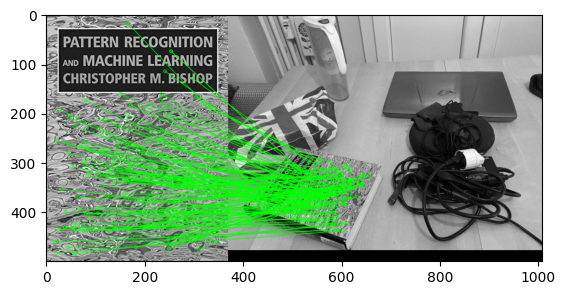

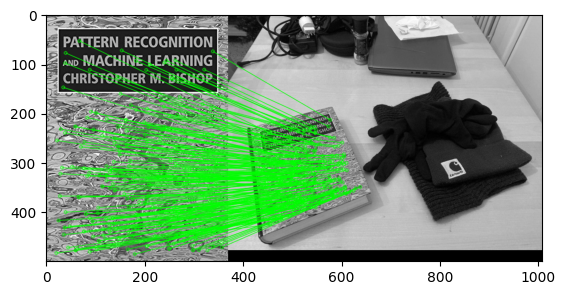

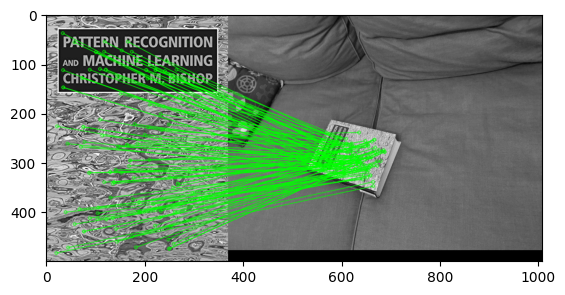

In [15]:
draw_matches("ex/bishop.jpg", "ex/scene1.jpg")
draw_matches("ex/bishop.jpg", "ex/scene2.jpg")
draw_matches("ex/bishop.jpg", "ex/scene3.jpg")

### Exercise 2: Image Search
Given a query image ('ex/bishop.jpg') and several train images ('ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg', 'ex/scene4.jpg', 'ex/scene5.jpg') implement an image search algorithm to find which images contain the query object.

['ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg']


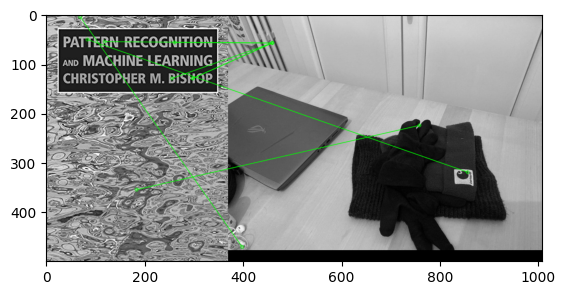

In [16]:
# Write your solution here
def detect_query_in_imgs(img_query_path, img_train_paths, min_match_count=10):
    detections = []

    img_query = cv2.imread(img_query_path, 0)
    kp_query, descr_query = find_descriptors(img_query)

    for path in img_train_paths:
        img_train = cv2.imread(path, 0)
        _, decr_train = find_descriptors(img_train)

        flann = init_descr_matcher(n_trees=5, n_checks=50)

        matches = flann.knnMatch(descr_query,decr_train,k=2)

        good = get_good_matches(matches, threshold=0.7)

        if len(good) >= min_match_count:
            detections.append(path)

    return detections

pprint(detect_query_in_imgs("ex/bishop.jpg", 
                            ["ex/scene1.jpg", "ex/scene2.jpg","ex/scene3.jpg","ex/scene4.jpg","ex/scene5.jpg"],
                            min_match_count=50))

draw_matches("ex/bishop.jpg", "ex/scene4.jpg")


### Exercise 3: Mosaicing (aka Panorama Stitching)
Given two images stitch them in a single image. 

Test it on 'ex/panorama_left_rgb.jpg' and 'ex/panorama_right_rgb.jpg' or 'ex/panorama_left.jpg' and 'ex/panorama_right.jpg'.

_Tips:_ 
* Find correspondences between the two images
* Find an homography
* Warp one image and restore values for the other image 

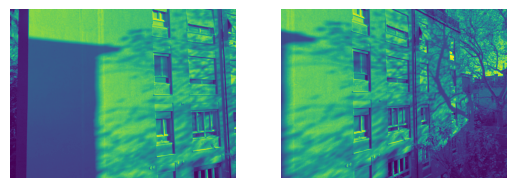

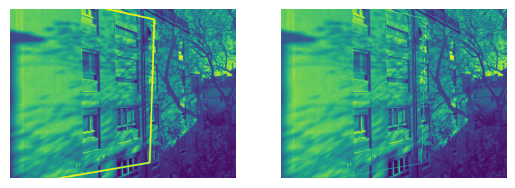

In [29]:
# Write your solution here
def stitch_images(img_query_path, img_train_path):
    img_query = cv2.imread(img_query_path, 0)
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(img_query)
    img_train = cv2.imread(img_train_path, 0)
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(img_train)
    plt.show()

    kp_query, descr_query = find_descriptors(img_query)
    kp_train, decr_train = find_descriptors(img_train)

    flann = init_descr_matcher(n_trees=5, n_checks=50)

    matches = flann.knnMatch(descr_query,decr_train,k=2)

    good = get_good_matches(matches, threshold=0.7)

    M, _ = get_homography_and_mask(kp_query, kp_train, good, min_match_count=10)
    
    ### plot contours of stitching
    h,w = img_query.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    
    # Projecting the corners into the train image
    dst = cv2.perspectiveTransform(pts,M)
    
    # Drawing the bounding box
    img_train = cv2.polylines(img_train,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(img_train)
    ###

    h_1, w_1 = img_train.shape[0], img_train.shape[1]
    h_2, w_2 = img_query.shape[0], img_query.shape[1]

    warped = cv2.warpPerspective(img_query, M, (w_1, h_1))

    white = np.ones([h_2,w_2],dtype=np.uint8)*255
    warp_mask = cv2.warpPerspective(white, M, (w_1, h_1)) # image all black except the white rectangle warped inside it
    warp_mask = np.equal(warp_mask, np.array([0]))

    warped[warp_mask] = img_train[warp_mask]
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(warped)
    plt.show()

# draw_matches("ex/panorama_left.jpg", "ex/panorama_right.jpg")

stitch_images("ex/panorama_left.jpg", "ex/panorama_right.jpg")



### Exercise 4: Augmentated Reality 
Given an image ('ex/stregatto.jpg') implement an augmented reality algorithm to project the image into the surface of the query object ('ex/bishop.jpg).

Moreover, restore the values of the original scene image instead of black pixels obtained with warping. 

Test it on scene images 'ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg'.

_Expected Results_:

<img src="LabSession6Images/ar_ex.png" width="400">

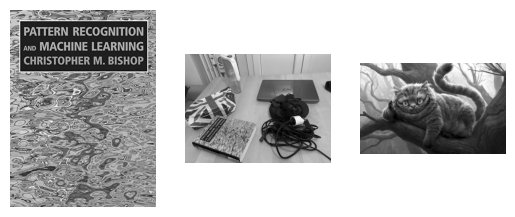

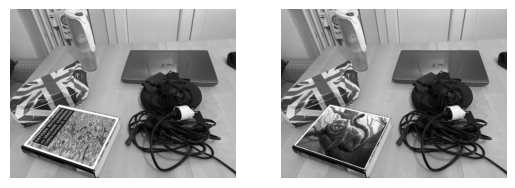

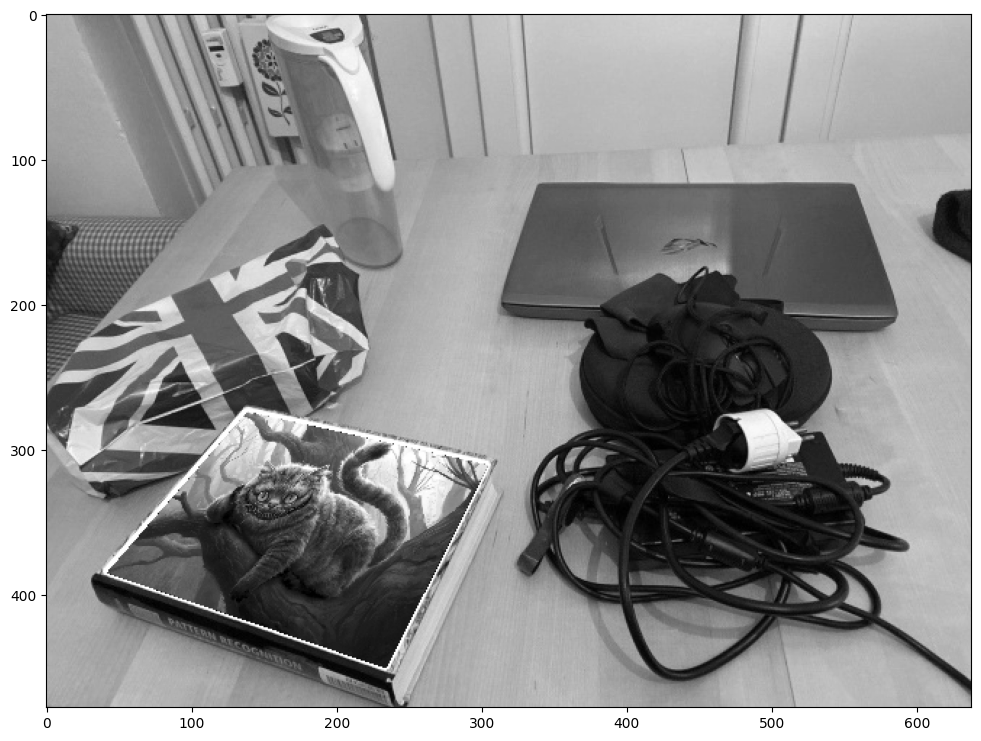

In [36]:
from collections import deque
# Write your solution here
def augment_scene(img_obj_path, img_scene_path, img_augmentation_path):
    img_obj = cv2.imread(img_obj_path, 0)
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.imshow(img_obj, cmap='gray', vmin=0, vmax=255)
    img_scene = cv2.imread(img_scene_path, 0)
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.imshow(img_scene, cmap='gray', vmin=0, vmax=255)
    img_augm = cv2.imread(img_augmentation_path, 0)
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.imshow(img_augm, cmap='gray', vmin=0, vmax=255)
    plt.show()

    kp_obj, descr_obj = find_descriptors(img_obj)
    kp_scene, decr_scene = find_descriptors(img_scene)

    flann = init_descr_matcher(n_trees=5, n_checks=50)

    matches = flann.knnMatch(descr_obj,decr_scene,k=2)

    good = get_good_matches(matches, threshold=0.7)

    M_obj_to_scene, _ = get_homography_and_mask(kp_obj, kp_scene, good, min_match_count=10)
    
    ### plot contours of stitching
    h,w = img_obj.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    
    # Projecting the corners into the train image
    obj_corners_in_scene = cv2.perspectiveTransform(pts,M_obj_to_scene)

    # rotate the image
    tmp = deque(obj_corners_in_scene)
    tmp.rotate(1)
    obj_corners_in_scene = np.stack(list(tmp))

    img_scene_countour = cv2.polylines(img_scene,[np.int32(obj_corners_in_scene)],True,255,3, cv2.LINE_AA)
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(img_scene_countour, cmap='gray', vmin=0, vmax=255)

    h_2, w_2 = img_augm.shape[0], img_augm.shape[1]
    augm_corners = np.float32([ [0,0],[0,h_2-1],[w_2-1,h_2-1],[w_2-1,0] ]).reshape(-1,1,2)
    M_augm_to_obj_in_scene = cv2.getPerspectiveTransform(augm_corners, obj_corners_in_scene)

    h_1, w_1 = img_scene.shape[0], img_scene.shape[1]

    warped = cv2.warpPerspective(img_augm, M_augm_to_obj_in_scene, (w_1, h_1))

    white = np.ones([h_2,w_2],dtype=np.uint8)*255
    warp_mask = cv2.warpPerspective(white, M_augm_to_obj_in_scene, (w_1, h_1)) # image all black except the white rectangle warped inside it
    warp_mask = np.equal(warp_mask, np.array([0]))

    warped[warp_mask] = img_scene[warp_mask]
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(warped, cmap='gray', vmin=0, vmax=255)
    plt.show()

    return warped

# draw_matches("ex/panorama_left.jpg", "ex/panorama_right.jpg")

final_image = augment_scene("ex/bishop.jpg", "ex/scene1.jpg", "ex/stregatto.jpg")
plt.figure(figsize=(16, 9))
plt.imshow(final_image, cmap='gray', vmin=0, vmax=255)
plt.show()